In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import csv
import seaborn as sns

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

In [4]:
# function for creating the X and y for the CRF 
def transform_to_crf(dataframe, strategy = 'LO', feature_group = [], base_group = []):
  """dataframe = entire train or development set as pandas dataframe
  strategy = 'LO' if you want to leave a certain group out of the analysis
  strategy = 'ONLY' if you want to train solely on that list of features
  strategy = 'STACK' if you want to stack the basegroup to the list of features 
  feature_group = the list of features on which the strategy is performed
  If you run transform_to_crf(dataframe) it will automatically perform on all features"""
  

  column_values = dataframe[['annotator']].values.ravel()
  annotator_ids = pd.unique(column_values)
  total_cols = ['token_no_stop','lemma','pos','prev_lemma','next_lemma','prev_pos','next_pos','snowball_stemmer',
                'porter_stemmer','head','dependency','is_part_of_negation','has_prefix','has_postfix','has_infix',
                'base_in_dictionary','has_apostrophe']

  if strategy == 'LO':
    cols = [x for x in total_cols if x not in feature_group]
  elif strategy == 'ONLY':
    cols = feature_group
  elif strategy == 'STACK':
    cols_dupl = base_group + feature_group
    cols = list(set(cols_dupl))


  X_ready = []
  y_ready = []

  for annotator in annotator_ids:  # for each annotator
      # get the data for the annotator
      annotator_data = dataframe[dataframe['annotator'] == annotator]
      # get the sentence ids
      column_values = annotator_data[['sentence_id']].values.ravel()
      sentence_ids = pd.unique(column_values)  # get the unique sentence ids

      for sent_id in sentence_ids:
        new_sentence = []
        sentence = annotator_data.loc[annotator_data['sentence_id']
                                            == sent_id]        
        y = sentence['label'].values.ravel()
        for i, token_features in sentence.iterrows():
          new_sentence.append(token_features[cols].to_dict())
        X_ready.append(new_sentence)
        y_ready.append(list(y))

  return X_ready, y_ready, cols

In [5]:
# function for creating the CRF classifier and predict the labels
def predictions_crf(X_train, y_train, X_test):

    crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
    )

    try:
        crf.fit(X_train, y_train)
    except AttributeError:
        pass

    predictions = crf.predict(X_test)
    
    return crf, predictions

In [6]:
# function for extracting the f1 and confusion matrix from the predictions
def get_metrics(predictions, y_test, crf):
    labels = list(crf.classes_)
    f1 = metrics.flat_f1_score(y_test, predictions,
                        average='macro', labels=labels)
    y_test_flatten = [y for x in y_test for y in x]
    predictions_flatten = [y for x in predictions for y in x]
    cm = confusion_matrix(y_test_flatten, predictions_flatten, labels)
    return cm, f1


In [7]:
# function for extracting all confusion matrices, f1's and prediction lists for every group of features
def run_feature_analysis(strat = 'LO', base_group = []):
    """strat = 'LO' if you want to leave a certain group out of the analysis
    strat = 'ONLY' if you want to train solely on that list of features 
    strat = 'STACK' if you want to increase the base_group 
    default is 'LO' """
    
    print('strategy: ', strat)
    
    feature_groups = [['token_no_stop'],['lemma','pos','snowball_stemmer','porter_stemmer'],['next_lemma','next_pos'], 
    ['prev_lemma', 'prev_pos'], ['head','dependency'], ['is_part_of_negation'], ['has_prefix','has_postfix','has_infix'],
    ['base_in_dictionary'],['has_apostrophe']]

    cms = []
    f1s = []
    predictions_list = []

    for i, group in enumerate(feature_groups):
        X_train, y_train, cols = transform_to_crf(train,  strategy = strat, feature_group=group, base_group= base_group)
        X_test, y_test, cols = transform_to_crf(dev, strategy = strat, feature_group=group, base_group = base_group)
        crf, predictions = predictions_crf(X_train, y_train, X_test)
        cm, f1 = get_metrics(predictions, y_test, crf)
        cms.append(cm)
        f1s.append(f1)
        predictions_list.append(predictions)
        print(cols, ' has f1 score of ', f1)
        
    return cms, f1s, predictions_list

In [13]:
# load data
train = pd.read_csv('SEM2012_training_data_with_features.csv', sep=",", header=0)
dev = pd.read_csv('SEM2012_validation_data_with_features.csv', sep=",", header=0)

# perform feature ablagation study
cms_only, f1s_only, predictions_list_only = run_feature_analysis(strat='ONLY')
cms_LO, f1s_LO, predictions_LO = run_feature_analysis(strat='LO')

strategy:  ONLY


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop']  has f1 score of  0.6087676599819579


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['lemma', 'pos', 'snowball_stemmer', 'porter_stemmer']  has f1 score of  0.6227473710985912


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['next_lemma', 'next_pos']  has f1 score of  0.3343824795342931


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['prev_lemma', 'prev_pos']  has f1 score of  0.3494603003249099


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['head', 'dependency']  has f1 score of  0.4836532211002666


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['is_part_of_negation']  has f1 score of  0.33020826204977305


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['has_prefix', 'has_postfix', 'has_infix']  has f1 score of  0.330070057734876


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['base_in_dictionary']  has f1 score of  0.33020826204977305


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['has_apostrophe']  has f1 score of  0.41385594479102394
strategy:  LO


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['lemma', 'pos', 'prev_lemma', 'next_lemma', 'prev_pos', 'next_pos', 'snowball_stemmer', 'porter_stemmer', 'head', 'dependency', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'base_in_dictionary', 'has_apostrophe']  has f1 score of  0.8883748016347953


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop', 'prev_lemma', 'next_lemma', 'prev_pos', 'next_pos', 'head', 'dependency', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'base_in_dictionary', 'has_apostrophe']  has f1 score of  0.8856514357651356


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop', 'lemma', 'pos', 'prev_lemma', 'prev_pos', 'snowball_stemmer', 'porter_stemmer', 'head', 'dependency', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'base_in_dictionary', 'has_apostrophe']  has f1 score of  0.8844824652178912


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop', 'lemma', 'pos', 'next_lemma', 'next_pos', 'snowball_stemmer', 'porter_stemmer', 'head', 'dependency', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'base_in_dictionary', 'has_apostrophe']  has f1 score of  0.8929378057715877


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop', 'lemma', 'pos', 'prev_lemma', 'next_lemma', 'prev_pos', 'next_pos', 'snowball_stemmer', 'porter_stemmer', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'base_in_dictionary', 'has_apostrophe']  has f1 score of  0.8899077842934346


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop', 'lemma', 'pos', 'prev_lemma', 'next_lemma', 'prev_pos', 'next_pos', 'snowball_stemmer', 'porter_stemmer', 'head', 'dependency', 'has_prefix', 'has_postfix', 'has_infix', 'base_in_dictionary', 'has_apostrophe']  has f1 score of  0.8899077842934346


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop', 'lemma', 'pos', 'prev_lemma', 'next_lemma', 'prev_pos', 'next_pos', 'snowball_stemmer', 'porter_stemmer', 'head', 'dependency', 'is_part_of_negation', 'base_in_dictionary', 'has_apostrophe']  has f1 score of  0.8892142267170655


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['token_no_stop', 'lemma', 'pos', 'prev_lemma', 'next_lemma', 'prev_pos', 'next_pos', 'snowball_stemmer', 'porter_stemmer', 'head', 'dependency', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'has_apostrophe']  has f1 score of  0.8883748016347953
['token_no_stop', 'lemma', 'pos', 'prev_lemma', 'next_lemma', 'prev_pos', 'next_pos', 'snowball_stemmer', 'porter_stemmer', 'head', 'dependency', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'base_in_dictionary']  has f1 score of  0.8899077842934346


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


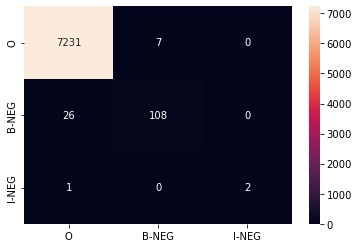

In [144]:
# f = sns.heatmap(cms_LO[0], annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

In [15]:
feature_groups = [['token_no_stop'],['lemma','pos','snowball_stemmer','porter_stemmer'],['next_lemma','next_pos'], 
    ['prev_lemma', 'prev_pos'], ['head','dependency'], ['is_part_of_negation'], ['has_prefix','has_postfix','has_infix'],
    ['base_in_dictionary'],['has_apostrophe']]

prev_max_value = 0

max_value = max(f1s_only)
max_index = f1s_only.index(max_value)
base_group = feature_groups[max_index]
print("Basegroup: ", base_group)
print("F1 score: ", max_value)

while max_value > prev_max_value:
    prev_max_value = max_value
    cms_STACK, f1s_STACK, predictions_STACK = run_feature_analysis(strat='STACK', base_group= base_group)
    max_value = max(f1s_STACK)
    max_index = f1s_STACK.index(max_value)
    base_group = base_group + feature_groups[max_index]
    print("Basegroup: ", base_group)
    print("F1 score: ", max_value)

Basegroup:  ['lemma', 'pos', 'snowball_stemmer', 'porter_stemmer']
strategy:  STACK


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'token_no_stop']  has f1 score of  0.6227473710985912


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'pos', 'porter_stemmer', 'lemma']  has f1 score of  0.6227473710985912


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'next_lemma', 'lemma', 'next_pos', 'pos']  has f1 score of  0.8860807036861601


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'prev_pos', 'prev_lemma']  has f1 score of  0.8829280698954761


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['dependency', 'snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'head']  has f1 score of  0.7848863569161623


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'is_part_of_negation']  has f1 score of  0.8920743176497652


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'has_prefix', 'lemma', 'has_infix', 'pos', 'has_postfix']  has f1 score of  0.624563800784093


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'base_in_dictionary']  has f1 score of  0.6227473710985912


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['has_apostrophe', 'snowball_stemmer', 'porter_stemmer', 'lemma', 'pos']  has f1 score of  0.6227473710985912
Basegroup:  ['lemma', 'pos', 'snowball_stemmer', 'porter_stemmer', 'is_part_of_negation']
F1 score:  0.8920743176497652
strategy:  STACK


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'token_no_stop', 'is_part_of_negation']  has f1 score of  0.8920743176497652


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'is_part_of_negation']  has f1 score of  0.8920743176497652


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'next_lemma', 'lemma', 'next_pos', 'pos', 'is_part_of_negation']  has f1 score of  0.8860807036861601


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'prev_pos', 'prev_lemma', 'is_part_of_negation']  has f1 score of  0.8829280698954761


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['dependency', 'snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'head', 'is_part_of_negation']  has f1 score of  0.8875548020445558


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'is_part_of_negation']  has f1 score of  0.8920743176497652


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8938603602374329


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'base_in_dictionary', 'is_part_of_negation']  has f1 score of  0.8920743176497652


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['has_apostrophe', 'snowball_stemmer', 'porter_stemmer', 'lemma', 'pos', 'is_part_of_negation']  has f1 score of  0.8920743176497652
Basegroup:  ['lemma', 'pos', 'snowball_stemmer', 'porter_stemmer', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix']
F1 score:  0.8938603602374329
strategy:  STACK


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'token_no_stop', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8938603602374329


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8938603602374329


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'next_lemma', 'lemma', 'has_prefix', 'has_infix', 'next_pos', 'pos', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8883748016347953


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'prev_pos', 'prev_lemma', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8879088133443673


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['dependency', 'snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'head', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8879088133443673


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8938603602374329


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8938603602374329


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


['snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'base_in_dictionary', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8926999503003922
['has_apostrophe', 'snowball_stemmer', 'porter_stemmer', 'lemma', 'has_prefix', 'has_infix', 'pos', 'is_part_of_negation', 'has_postfix']  has f1 score of  0.8938603602374329
Basegroup:  ['lemma', 'pos', 'snowball_stemmer', 'porter_stemmer', 'is_part_of_negation', 'has_prefix', 'has_postfix', 'has_infix', 'token_no_stop']
F1 score:  0.8938603602374329


/Users/ravimeijer/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-NEG', 'I-NEG'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
